# __Building a Movie Recommender with the MovieLens Dataset__



__Group One Members__
* Esther Francis - Phase Four Group Leader
* Doreen Wanjiru
* Ian Korir
* Gregory Mikuro - Scrum Master

__Team Responsibilities:__ https://github.com/users/gregorymikuro/projects/4 

__Student pace:__ Hybrid

__Instructor name:__ Nikita Njoroge
 

## __1.0 Business Understanding__

### 1.1 Overview
In the age of streaming services and an abundance of movie alternatives, customers frequently face the issue of finding films that match their preferences. This project aims to build a movie recommendation system that enhances the user’s movie-watching experience by suggesting films tailored to their preferences. The system will utilize machine learning algorithms and user data to deliver tailored movie suggestions based on ratings, viewing history, and preferences, resulting in growth and competitive advantage in the entertainment industry.
The target audience for this project is companies that provide movie streaming services, such as Netflix, Amazon Prime Video, or Hulu. These companies can, in turn, use recommendation systems to increase their customer engagement and retention.


### 1.2 Problem statement
In the vast and ever-expanding landscape of film and television content, users often face the challenge of discovering movies that align with their personal tastes and preferences. With countless options available across multiple platforms, finding enjoyable and relevant movies can be overwhelming and time-consuming. Traditional methods of browsing and searching are often inefficient, leading to decision fatigue and a suboptimal viewing experience. We aim to develop a Movie Recommender System that addresses this problem by providing users with personalized, relevant, and timely movie recommendations.


### 1.3 General Objective
To develop and implement a Movie Recommender System that delivers personalized and relevant movie suggestions to users, thereby improving their movie discovery experience and increasing their satisfaction with their entertainment choices.


### 1.4 Specific Objectives

1. Analyze and determine movie ratings by calculating the Bayesian average to ensure that ratings are representative and not overly influenced by the number of raters, taking into account both the average rating and the number of votes.

2. Investigate relationships between user preferences and movie features through matrix factorization techniques, such as Singular Value Decomposition (SVD). This will help in understanding how latent factors can capture the underlying patterns in user-movie interactions, ultimately leading to more personalized recommendations.

3. Create a hybrid recommendation model that integrates collaborative filtering (with a target accuracy of 80% or higher) with content-based filtering, specifically using deep learning techniques.

4. Deploy the developed recommendation system using Streamlit, creating an interactive interface that allows users to receive personalized movie recommendations in real-time.

### 1.5 Challenges
1. Cold start problem: Accurate recommendations will be complex to provide when there is limited data for new users or at the system's initial launch.
2. Scalability: Managing and processing large volumes of user data and movie metadata will be challenging as the system grows.
3. Algorithm Complexity: Balancing the complexity of recommendation algorithms with the need for real-time performance will be a challenge. More sophisticated algorithms might improve recommendation quality but could increase computational demands and processing time.
4. Diverse User Preferences: There will be issues when effectively handling a wide range of user tastes and preferences because failure to accommodate diverse preferences can result in recommendations that do not resonate with a large segment of users.
5. Handling Challenging Trends: Adapting to changes in user preferences and trends, such as seasonal interests or emerging genres, whereby recommendations may become outdated or irrelevant if the system cannot adapt quickly to changing user tastes.


## __2.0 Data Understanding__

The dataset ml-latest-small is from (https://grouplens.org/datasets/movielens/latest/)
It describes 5-star ratings and free-text tagging activity from movieLens, a movie recommendation system. The data contained 100836 ratings across 9742 movies and was generated on September 26th, 2018. Users were selected randomly for inclusion and all the users had rated at least 20 movies.

#### Summary of Features in the Dataset

* User_Id: A unique identifier for each user
* MovieId: A unique identifier for each movie and is consistent in the dataset in ratings, tags, movies, and links.
* TimeStamp: Represents seconds since midnight in Coordinated Universal Time (UTC).
* Tags: User-generated metadata about movies. Each tag is typically a single word or short phrase where each user determines a particular tag's meaning, value and purpose.
* Genre: Pipe-separated list, selected from Actions, Adventure, Animation, Children’s, Comedy, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fic, Thriller, War, Western, no genres listed.

#### _Citation_

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. https://doi.org/10.1145/2827872


## __3.0 Data Preparation__ 

In [15]:
# import libraries and classes
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from surprise import Reader, Dataset, SVD
from wordcloud import WordCloud
from scipy import sparse
from surprise import Reader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import process
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from surprise.model_selection import cross_validate
from sklearn.decomposition import TruncatedSVD
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import pickle
from main import MovieLensDataExplorer, MovieLensDataCleaner, MovieLensUnivariateEDA, MovieLensBivariateEDA, MultivariateAnalysis, DataPreprocessing, HybridRecommender, CollaborativeFiltering


In [16]:
explorer = MovieLensDataExplorer('data/ratings.csv', 'data/movies.csv', 'data/links.csv', 'data/tags.csv')

In [17]:
# Basic Info
explorer.show_info() 


## Ratings Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None

## Movies Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None

## Links Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movi

* The MovieLens dataset contains 100,836 ratings from 610 users on 9,742 movies, with additional movie metadata (titles, genres) and links to external databases.

* The dataset also includes 3,683 user-provided tags for movies, though this represents a small fraction of the total movie-rating interactions. 

In [18]:
# overview and summary of stats
explorer.overview()



## Ratings Data Overview:
| userId   | movieId   | rating   | timestamp   |
|:---------|:----------|:---------|:------------|
| 1        | 1         | 4        | 9.64983e+08 |
| 1        | 3         | 4        | 9.64981e+08 |
| 1        | 6         | 4        | 9.64982e+08 |
| 1        | 47        | 5        | 9.64984e+08 |
| 1        | 50        | 5        | 9.64983e+08 |

Shape: (100836, 4)
|           | Unique Values   | Missing Values   | % Missing   |
|:----------|:----------------|:-----------------|:------------|
| userId    | 610             | 0                | 0           |
| movieId   | 9724            | 0                | 0           |
| rating    | 10              | 0                | 0           |
| timestamp | 85043           | 0                | 0           |

## Movies Data Overview:
| movieId   | title                              | genres                                      |
|:----------|:-----------------------------------|:---------------------------------------

* Consistent Movie IDs: The movieId column appears consistently across the ratings, movies, and links datasets, facilitating seamless integration for analysis.
* Sparse Tags Data: The tags dataset is significantly smaller than the ratings dataset, indicating that not all users provide tags for the movies they rate. This suggests that tags might offer a more focused view of specific movie attributes.
* Missing tmdb IDs: There are 8 missing values in the tmdbId column of the links dataset (0.08%).

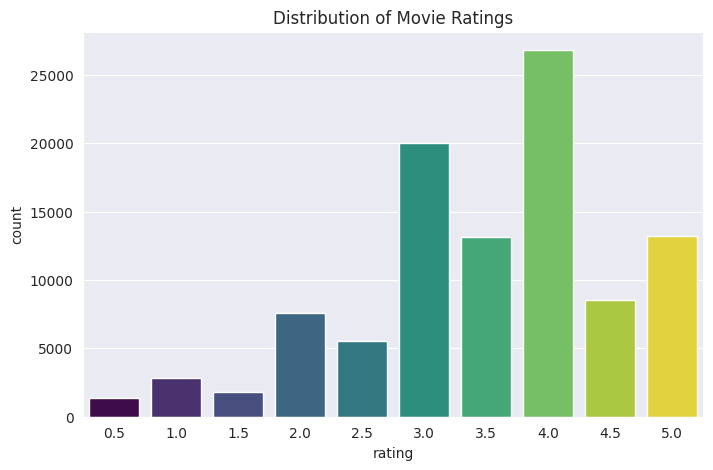

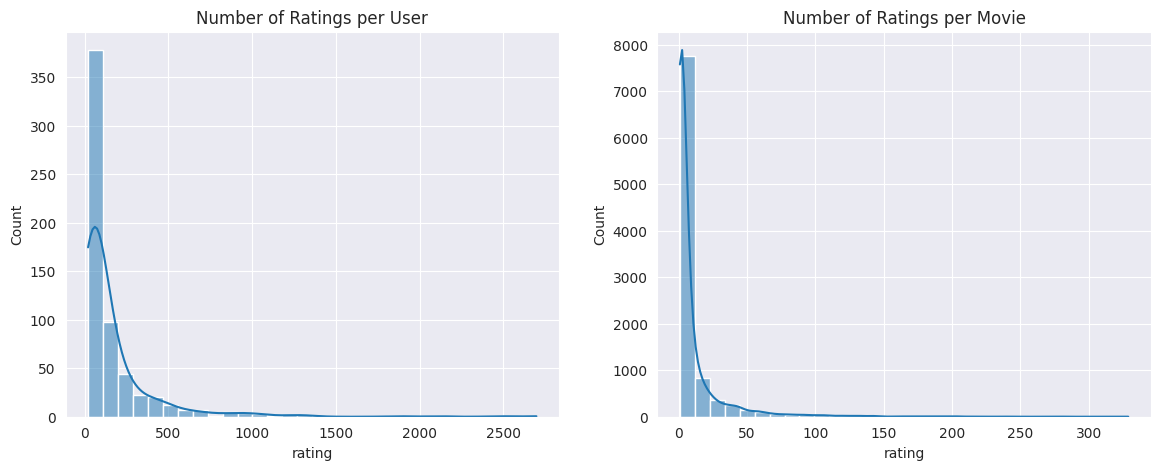

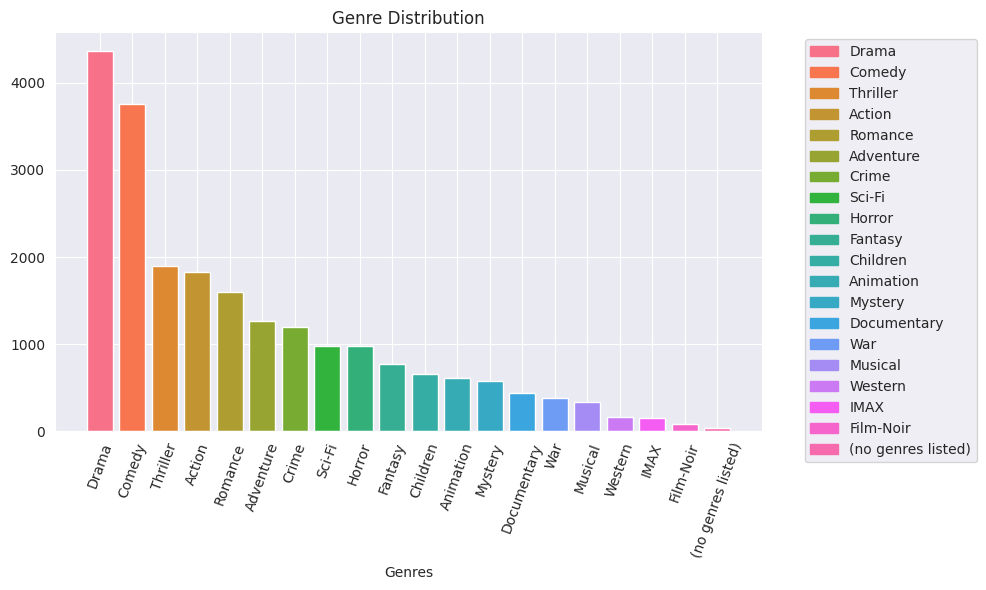

In [19]:
# Overall distributions
explorer.visualize()


* Rating Preferences: The most common ratings are 4 and 3, indicating a general tendency towards positive reviews, but also a significant portion of average ratings.
* Power Users and Popular Movies: A few users have rated a large number of movies (the long tail in the 'Number of Ratings per User' distribution), and a few movies have received a large number of ratings (the long tail in 'Number of Ratings per Movie' distribution). These outliers could significantly influence collaborative filtering recommendations.
* Genre Diversity: The dataset covers a wide range of genres, but some are more prevalent than others (e.g., Drama, Comedy, Thriller). This suggests that the recommender system might need to handle genre imbalances or incorporate content-based filtering to recommend movies from less popular genres.

## __4.0 Data Cleaning__ 

In this analysis, we'll prioritize the core user-item interactions captured in the `ratings` and `movies` datasets.  The `links` dataset, providing links to external databases (IMDb and TMDb), is not directly relevant to our collaborative filtering approach and will be excluded.  While the `tags` dataset offers potentially valuable insights into movie content, its inherent sparsity (only 3683 tags compared to 100,836 ratings) and potential user bias pose challenges for its inclusion in this initial analysis.

Our data cleaning strategy aims to refine the dataset for subsequent analysis and modeling:

1.  **Merge `ratings` and `movies`:** We'll merge the `ratings` and `movies` DataFrames on the `movieId` column. This consolidation is essential for associating user ratings with specific movie titles and genres, enabling us to examine user preferences in relation to movie attributes and facilitating various recommendation strategies.

2.  **Timestamp Removal:** The `timestamp` column, while potentially useful for temporal analysis, is not immediately relevant.  Therefore, we'll drop this column to reduce the dataset's dimensionality and computational burden.

3.  **Duplicate Elimination:** We'll rigorously identify and remove duplicate entries within the merged DataFrame, ensuring each user-movie rating pair is unique. This step is crucial to prevent biases in subsequent analyses and models arising from duplicate ratings.

4.  **Genre Transformation:** The `genres` column in the `movies` DataFrame contains multiple genres per movie separated by '|'. We'll split this column into a list of individual genres to enable genre-based analysis and filtering, as well as potential integration into content-based filtering strategies if desired later.

5. **Title-Year Separation:** We will also extract the release year from the movie title and store it as a separate column for further analysis.
 
6. **Bayesian Average Calculation:** We'll compute the Bayesian Average for each movie's rating.  This approach mitigates the inherent bias of simple average ratings, especially for movies with few ratings, by incorporating the global average rating and the average number of votes per movie. The Bayesian Average formula is:

```
Bayesian Average = ( (C * m) + (R * v) ) / (C + v)
```

where:

*   R = average rating for the movie
*   v = number of votes for the movie
*   m = average rating across all movies
*   C = average number of votes per movie across all movies

By comparing the Bayesian Average with simple average ratings, we'll assess the impact of this adjustment on the perceived popularity of movies, particularly those with limited ratings. We'll visually represent this comparison to discern how the Bayesian Average smooths out the rating distribution.


In [20]:
cleaner = MovieLensDataCleaner('data/ratings.csv', 'data/movies.csv', min_reviews=50)

In [21]:
cleaned_df = cleaner.clean_and_merge()
cleaned_df

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,1,3,4.0,Grumpier Old Men,"[Comedy, Romance]",1995
2,1,6,4.0,Heat,"[Action, Crime, Thriller]",1995
3,1,47,5.0,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995
4,1,50,5.0,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995
...,...,...,...,...,...,...
100831,610,166534,4.0,Split,"[Drama, Horror, Thriller]",2017
100832,610,168248,5.0,John Wick: Chapter Two,"[Action, Crime, Thriller]",2017
100833,610,168250,5.0,Get Out,[Horror],2017
100834,610,168252,5.0,Logan,"[Action, Sci-Fi]",2017


In [22]:
df_with_bayesian_avg = cleaner.calculate_bayesian_average()
df_with_bayesian_avg

,userId,movieId,rating,title,genres,year,avg_rating
0,1,1,4.0,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,3.841803
1,1,3,4.0,Grumpier Old Men,"[Comedy, Romance]",1995,3.378214
2,1,6,4.0,Heat,"[Action, Crime, Thriller]",1995,3.799854
3,1,47,5.0,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995,3.881731
4,1,50,5.0,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995,4.092826
...,...,...,...,...,...,...,...
100831,610,166534,4.0,Split,"[Drama, Horror, Thriller]",2017,3.483533
100832,610,168248,5.0,John Wick: Chapter Two,"[Action, Crime, Thriller]",2017,3.580313
100833,610,168250,5.0,Get Out,[Horror],2017,3.531967
100834,610,168252,5.0,Logan,"[Action, Sci-Fi]",2017,3.761038


The Bayesian Average rating significantly adjusts the perceived ranking of movies with few ratings, potentially elevating lesser-known films in the recommendations. Movies with many ratings experience minimal adjustments, as their average rating is already a reliable indicator of popularity. No duplicate ratings were found in the dataset, ensuring the integrity of subsequent analyses.

In [23]:
cleaner.save_cleaned_data()

Cleaned data saved to: data/cleaned-data.csv


## __5.0 Exploratory Data Analysis__

### __5.1 Univariate Analysis__

The `MovieLensUnivariateEDA` class below performs exploratory data analysis on a MovieLens dataset. It analyzes the distribution of movie ratings, identifies the most and least common genres, assesses the relationship between movie popularity and average ratings, examines the distribution of movies over time, and identifies the top and bottom rated movies and users.

In [24]:
eda = MovieLensUnivariateEDA()  


### Rating Distribution Analysis:


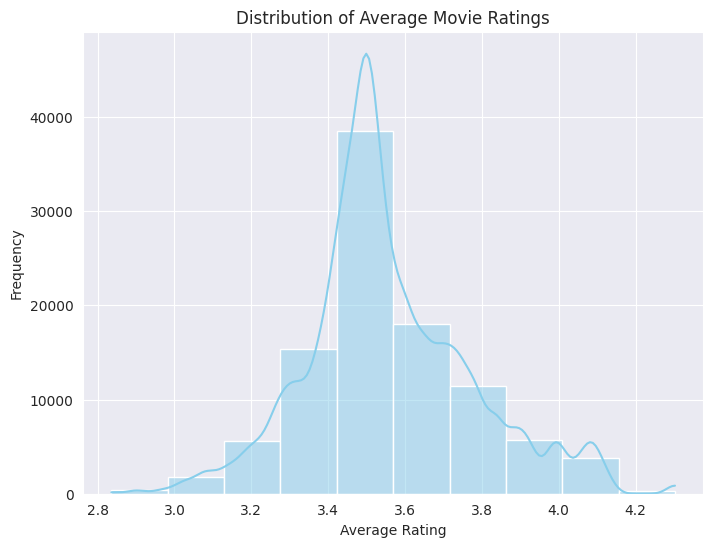

In [25]:
eda.analyze_ratings()


### Genre Analysis:


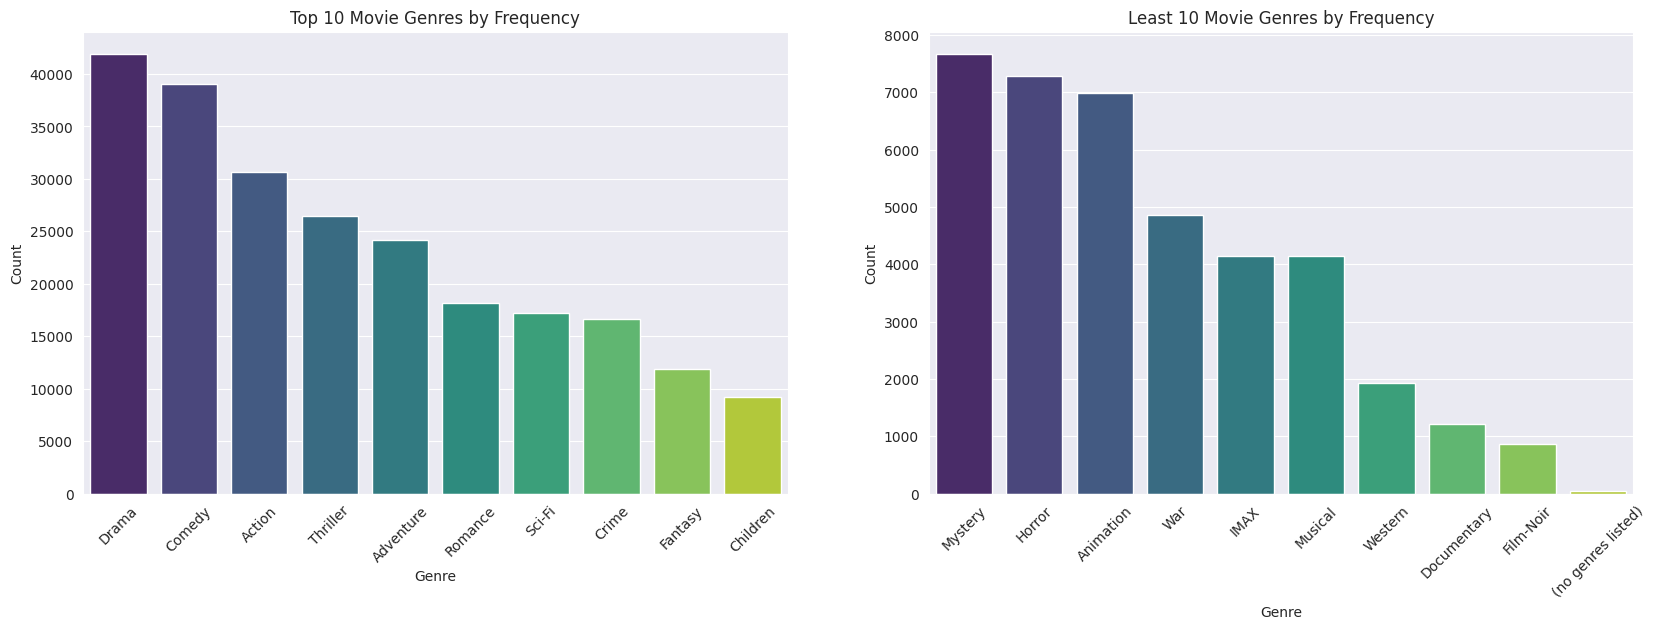

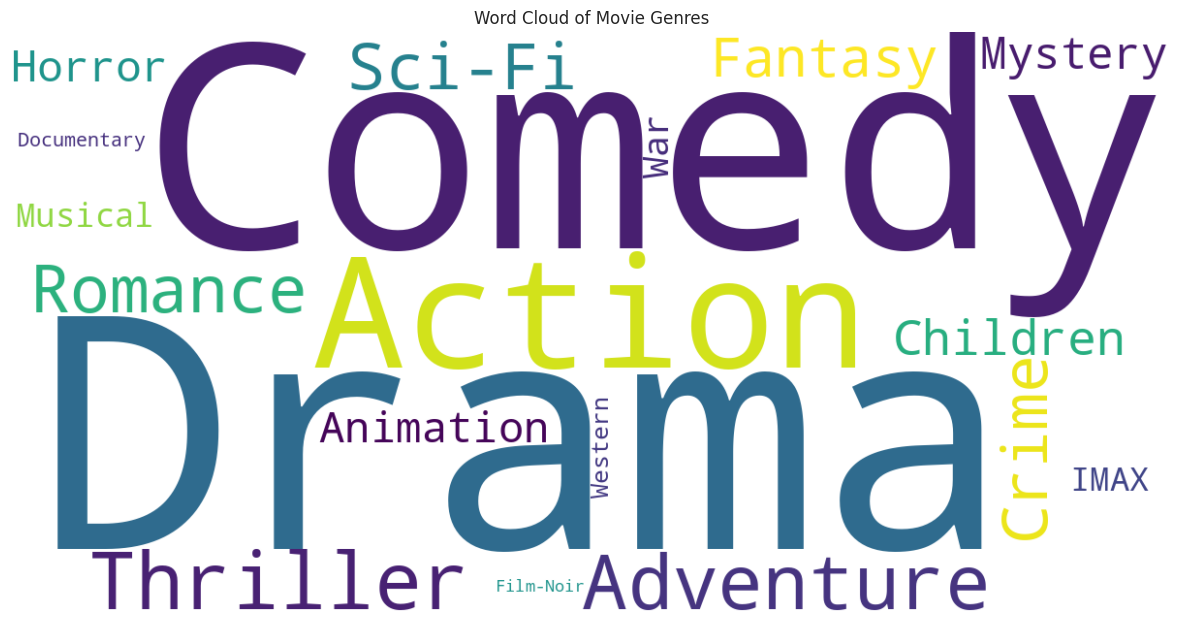

In [26]:
eda.analyze_genres()


### Movie Popularity Analysis:


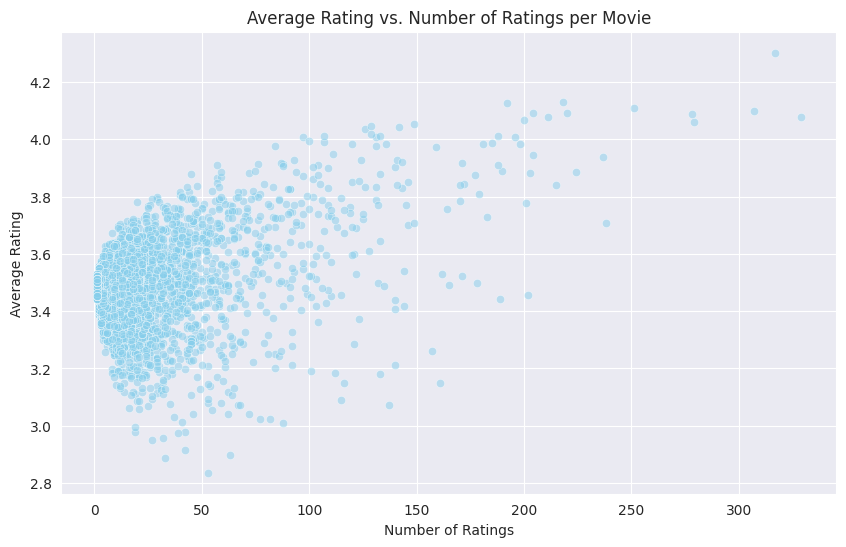

In [27]:
eda.analyze_popularity()


### Year Analysis:


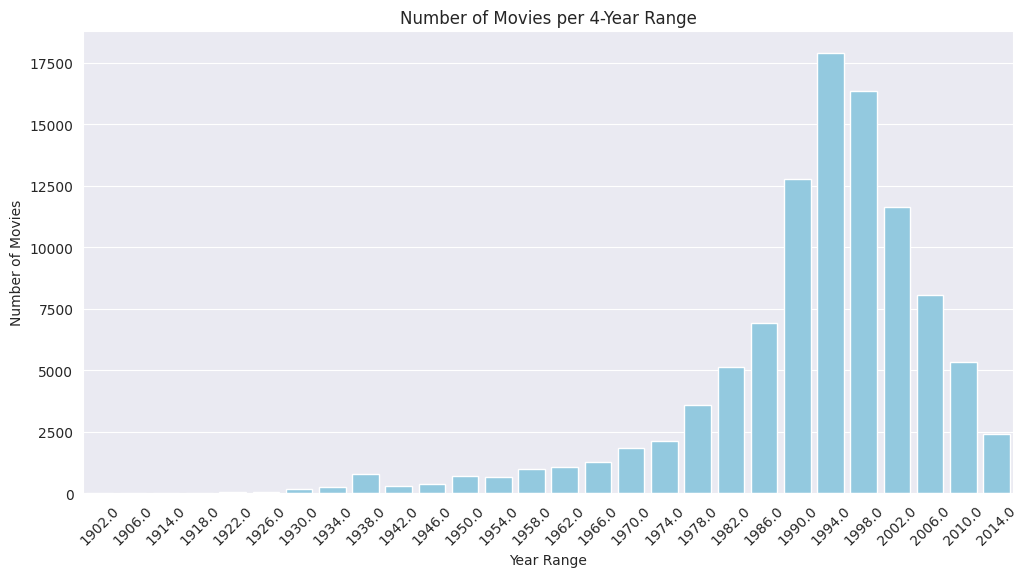

In [28]:
eda.analyze_years()

In [29]:
eda.analyze_top_bottom()


### Top and Bottom Rated Movies & Users:

Top Rated Movies:
| title                              | avg_rating   |
|:-----------------------------------|:-------------|
| Shawshank Redemption, The          | 4.30266      |
| Fight Club                         | 4.12902      |
| Godfather, The                     | 4.12635      |
| Star Wars: Episode IV - A New Hope | 4.10989      |
| Pulp Fiction                       | 4.09966      |

Bottom Rated Movies:
| title                           | avg_rating   |
|:--------------------------------|:-------------|
| Wild Wild West                  | 2.83571      |
| Coneheads                       | 2.89892      |
| Batman & Robin                  | 2.91389      |
| Anaconda                        | 2.94906      |
| I Know What You Did Last Summer | 2.95827      |

Top Raters (By Average Rating):
| userId   | avg_rating   |
|:---------|:-------------|
| 549      | 3.94902      |
| 189      | 3.94202      |
| 251      | 3.93876      |
| 231    

### __5.2 Bivariate Analysis__

The MovieLensBivariateEDA class below performs bivariate analysis on the MovieLens dataset. It investigates the relationship between the average movie rating and two other variables: year of release and genre. This helps us understand how ratings vary depending on when a movie was released and what genre it belongs to. 


### Year vs. Average Rating Analysis:


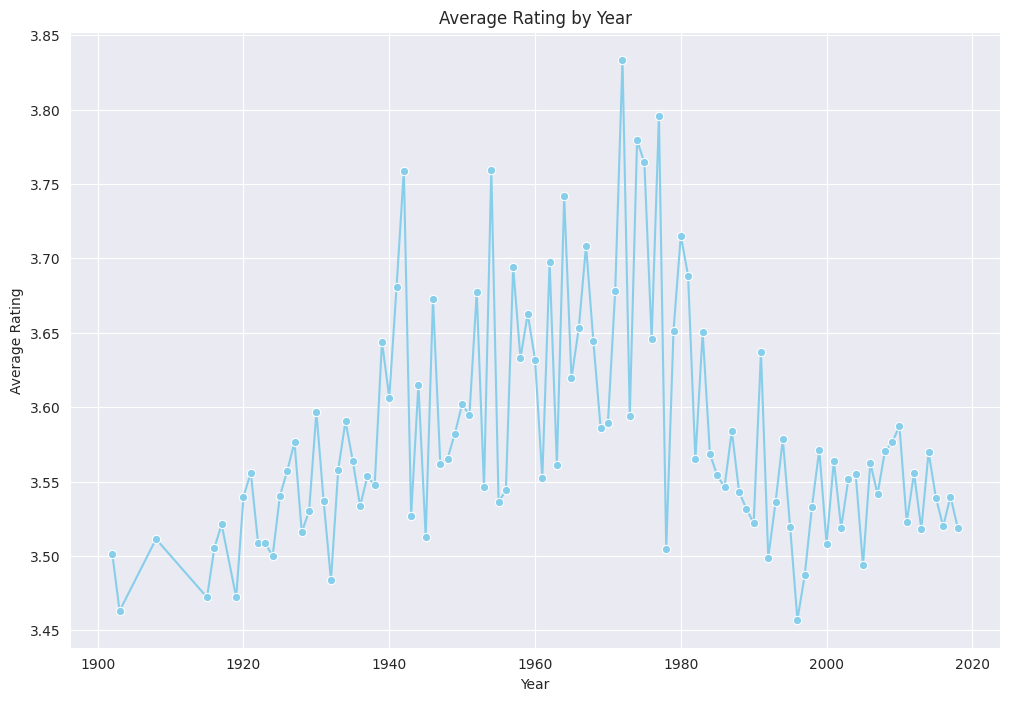


### Genres vs. Average Rating Analysis:


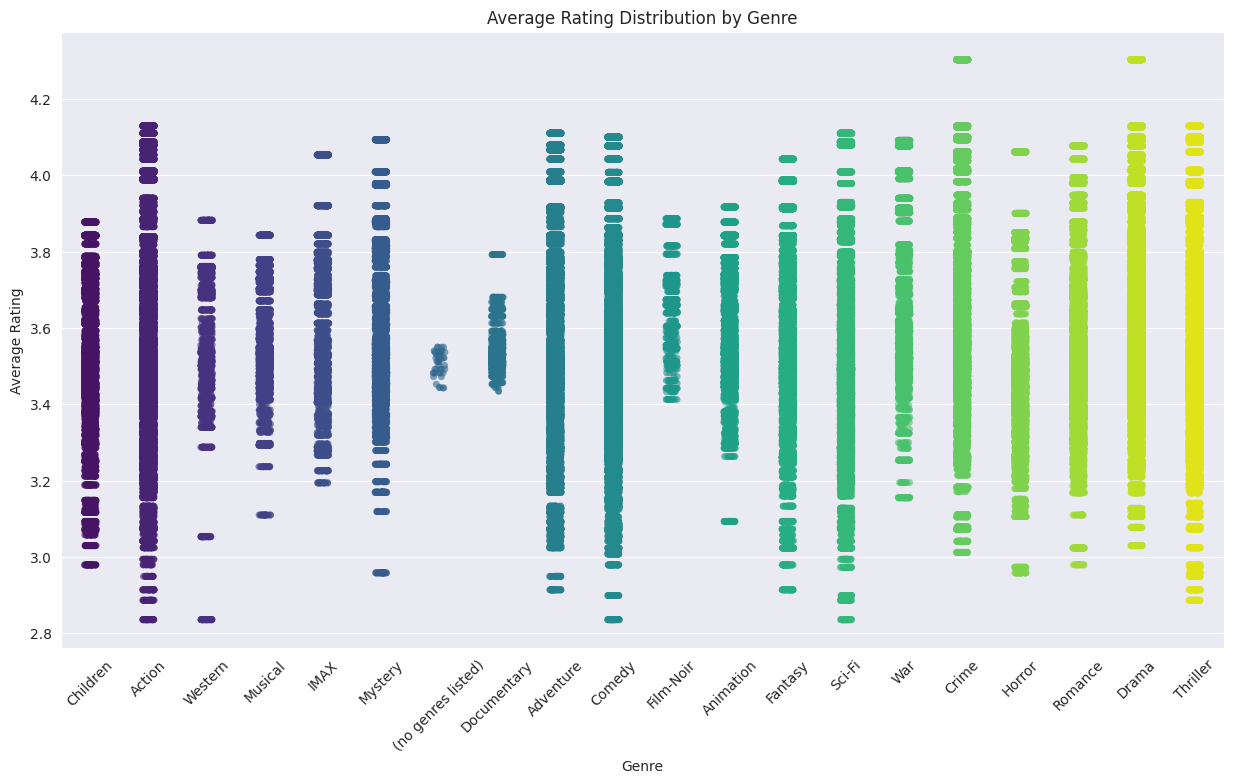

In [30]:
eda = MovieLensBivariateEDA('data/cleaned-data.csv')
eda.analyze_year_vs_avg_rating()
eda.analyze_genres_vs_avg_rating()

analyze_year_vs_avg_rating() method calculates and visualizes the average rating of movies for each year using a line plot. It reveals trends in how movie ratings have evolved over time while analyze_genres_vs_avg_rating() method creates a new DataFrame with individual rows for each movie-genre combination along with their average ratings. It then uses a strip plot to visualize the distribution of average ratings across different genres, helping to identify if certain genres tend to receive higher or lower ratings on average.

### __5.3 Multivariate Analysis__ 

The `MultivariateAnalysis` class begins by initializing with a file path to the CSV data and the number of latent features for dimensionality reduction, which is set via `n_components`. It reads the data from the specified file using Pandas and prepares it for analysis. The `_prepare_data` method maps each movie ID to its title and index, then formats the data for the Surprise library, which is used to train the SVD model. The SVD model, initialized with the specified number of latent features, is trained on the prepared dataset. For similarity calculations, the `find_similar_movies` method computes the cosine similarity between the target movie vector and all other movie vectors. It then retrieves the top `k` most similar movies, excluding the target movie itself. The `plot_similarity_heatmap` method visualizes the similarity between the target movie and its top `k` similar movies by creating a heatmap, with movie titles as labels and similarity scores as annotations. Both methods include error handling to ensure the provided movie ID exists in the dataset. The cosine similarity is computed using the equation:

\[
\text{similarities} = \text{cosine\_similarity(movie\_vector, all\_movie\_vectors)}
\]

When generating the heatmap, the similarity matrix is computed with:

\[
\text{similarity\_matrix} = \text{cosine\_similarity(selected\_vectors)}
\]

In the `__main__` section, the class is instantiated with the data path and number of components, and methods are executed to find similar movies and plot the heatmap.

Movies similar to Sabrina:
Project X
Cincinnati Kid, The
Encounters at the End of the World
World of Apu, The (Apur Sansar)
Fist of Fury (Chinese Connection, The) (Jing wu men)


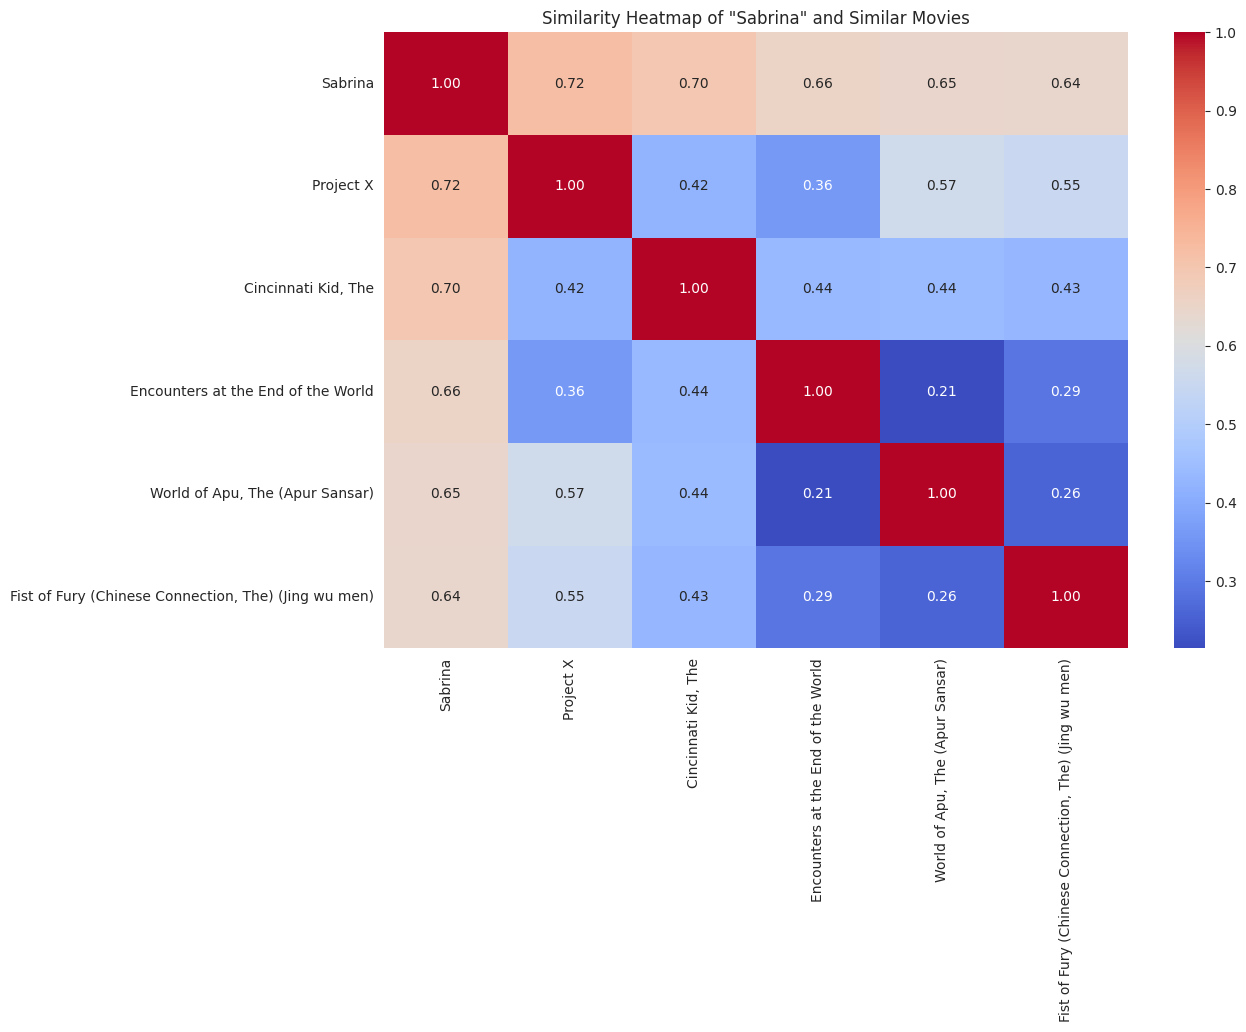

In [31]:
if __name__ == "__main__":
    data_path = 'data/cleaned-data.csv'
    analysis = MultivariateAnalysis(data_path, n_components=20)

    movie_id = 7  # Example movieId
    similar_movies = analysis.find_similar_movies(movie_id)

    print(f"Movies similar to {analysis.movie_titles[movie_id]}:")
    for movie in similar_movies:
        print(movie)

    # Plot the similarity heatmap for the movie and its similar movies
    analysis.plot_similarity_heatmap(movie_id)

## __6.0 Modeling and Evaluation__

### __6.1 Data Pre-Processing__

The `DataPreprocessing` class initializes by loading data from a specified file path using Pandas. The `preprocess` method converts genre strings into lists, creates a user-item matrix, and generates a genre matrix. It first maps user and movie IDs to indices and vice versa, then builds a sparse user-item matrix using these indices and ratings. Additionally, it creates a binary genre matrix using `MultiLabelBinarizer`. Finally, the class is instantiated, and preprocessing is executed to obtain matrices and mappings, with movie titles indexed by movie ID.

In [32]:
# Load and preprocess data
data_preprocessing = DataPreprocessing('data/cleaned-data.csv')
X, genre_matrix, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = data_preprocessing.preprocess()
movie_titles = data_preprocessing.data.set_index('movieId')['title'].to_dict()


### 6.1 __Modeling__

#### 6.1.1 Collaborative Filtering - Baseline Model

The `CollaborativeFiltering` class is designed to recommend movies similar to a given movie based on collaborative filtering techniques. Upon initialization, it stores the user-item matrix \( \mathbf{X} \), movie titles, and various mappings for users and movies. The `find_similar_movies` method identifies similar movies using the specified distance metric, either 'cosine' or 'euclidean'. It transposes the user-item matrix \( \mathbf{X} \) and checks if the movie ID exists in the dataset. If valid, it retrieves the movie vector and applies the `NearestNeighbors` algorithm to find the closest neighbors. The cosine similarity or Euclidean distance is computed as:

\[
d_{ij} = \sqrt{\sum_{k=1}^{n} (x_{ik} - x_{jk})^2}
\]

where \( x_{ik} \) and \( x_{jk} \) are the feature values for movies \( i \) and \( j \), respectively. It then excludes the movie itself from the results and maps the indices back to movie titles. The `cf_model` instance is created to find and print the top 5 similar movies for a specified movie ID.

In [33]:
# Collaborative filtering model
cf_model = CollaborativeFiltering(X, movie_titles, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper)
similar_movies_cf = cf_model.find_similar_movies(movie_id=7, k=5)

print(f"Collaborative Filtering Recommendations for Movie ID 7:")
for title in similar_movies_cf:
    print(title)

Collaborative Filtering Recommendations for Movie ID 7:
Truth About Cats & Dogs, The
Father of the Bride Part II
Birdcage, The
Mr. Holland's Opus
Sense and Sensibility


The collaborative filtering approach has generated a list of tailored movie recommendations for Movie ID 7, featuring titles such as *The Birdcage* and *Sense and Sensibility*. This method effectively leverages user behavior and preferences to suggest relevant films. However, it’s important to acknowledge the potential for the cold start problem, which might impact the accuracy of recommendations for newly introduced or less frequently rated movies. Despite this, the current results reflect the system’s capacity to provide insightful and varied movie choices based on existing user interactions. There is a need to focus on addressing these cold start issues to further refine the recommendation accuracy.

### 6.1.2 Hybrid Approach 

The `HybridRecommender` class integrates content-based and collaborative filtering approaches to provide movie recommendations. It initializes with a user-item matrix \( \mathbf{X} \), a genre matrix, and various mappings for users and movies, along with thresholds for user and movie ratings. The `movie_finder` method uses fuzzy matching to find the closest movie title to a given input. The `get_content_based_recommendations` method computes similarity scores between the target movie's genre vector and all other genre vectors using cosine similarity:

\[
\text{sim\_scores} = \text{cosine\_similarity}(\mathbf{g}_{\text{target}}, \mathbf{G})
\]

where \( \mathbf{g}_{\text{target}} \) is the genre vector of the target movie, and \( \mathbf{G} \) is the matrix of all genre vectors. The `get_collaborative_recommendations` method identifies similar movies using collaborative filtering based on nearest neighbors and computes distances using either 'cosine' or 'euclidean' metrics. The `hybrid_recommendations` method decides whether to use content-based or collaborative filtering based on the user's rating history or the movie's rating history. It applies filtering based on thresholds for user and movie ratings to choose the most appropriate recommendation approach.

In [34]:
# Load and preprocess data
data_preprocessing = DataPreprocessing('data/cleaned-data.csv')
X, genre_matrix, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = data_preprocessing.preprocess()
movie_titles = data_preprocessing.data.set_index('movieId')['title']

# Hybrid recommender model
hybrid_model = HybridRecommender(X, genre_matrix, user_mapper, movie_mapper, movie_titles, user_inv_mapper,
                                 movie_inv_mapper)
hybrid_recommendations = hybrid_model.hybrid_recommendations(title_string='Toy Strry', user_id=1,
                                                             n_recommendations=5)  # spelled movie title wrong intentionally

print(f"Hybrid Recommendations for 'Toy Story':")
for title in hybrid_recommendations:
    print(title)


Using collaborative filtering based on user history.
Hybrid Recommendations for 'Toy Story':
Independence Day (a.k.a. ID4)
Jurassic Park
Forrest Gump
Star Wars: Episode IV - A New Hope
Mission: Impossible


The hybrid recommendation system has successfully provided a diverse set of movie suggestions based on user history and content-based filtering. The recommendations, demonstrate the model's capability to blend collaborative and content-based approaches effectively. By integrating user preferences with movie attributes, the system enhances the relevance of suggested titles. This method not only addresses the cold start problem but also ensures that the recommendations cater to various user tastes.

## The __deeplearning.ipynb__ contains the rest of the models and sections